<a href="https://colab.research.google.com/github/securemindorg/Educational-Examples/blob/main/Monte_Carlo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Change the following the match your situation

In [13]:
NUM_SIMULATIONS = 1000  # Number of potential futures to run
YEARS = 25              # Investment horizon (Years until you plan on retiring) (Retirement Age minus current age)
ANNUAL_CONTRIBUTION = 10000 # this is only for retirement accounts, I'll need to update the code to account for CD and HYSA contribs,
# there will be some variability here because this assumes lump sum once a year contrib, not monthly

# Starting balances for each account type, this does not include 529's since that money typically is assumed to be spent
accounts = {
    #fixed investments
    "High Yield Savings": 10000,
    "CD (5-Year)": 0,
    #variable investments
    "403b": 0,
    "401a": 80000,
    "401k": 0,
    "IRA": 0,
    "Roth IRA": 0,
    "SEP IRA": 0,
    "HSA": 0
}

# Define Interest/Growth Rates
HYSA_RATE = 0.0381     # 4.5% fixed annual interest for HYSA
CD_RATE = 0.052       # 5.2% fixed annual interest for CD

# Market Assumptions (Applied only to market-invested accounts)
MARKET_EXPECTED_RETURN = 0.105  # 10% average annual return
MARKET_VOLATILITY = 0.18       # 18% standard deviation

# Split Starting Balances
FIXED_BALANCE = accounts["High Yield Savings"] + accounts["CD (5-Year)"]
MARKET_BALANCE = sum(v for k, v in accounts.items() if k not in ["High Yield Savings", "CD (5-Year)"])
TOTAL_STARTING_BALANCE = FIXED_BALANCE + MARKET_BALANCE

# For simplicity, assume new contributions go to the market bucket
MARKET_CONTRIBUTION = ANNUAL_CONTRIBUTION
FIXED_CONTRIBUTION = 0

Run the simulation

In [14]:
results = np.zeros((YEARS, NUM_SIMULATIONS))
# results[0] is set in the loop start

for sim in range(NUM_SIMULATIONS):
    current_market_balance = MARKET_BALANCE
    current_fixed_balance = FIXED_BALANCE

    # Set starting value for the first year
    results[0, sim] = TOTAL_STARTING_BALANCE

    for year in range(1, YEARS):
        # 1. Calculate Market Account Growth (Random/Volatile)
        market_annual_return = np.random.normal(MARKET_EXPECTED_RETURN, MARKET_VOLATILITY)

        # Growth calculation for market accounts
        current_market_balance = current_market_balance * (1 + market_annual_return) + MARKET_CONTRIBUTION
        current_market_balance = max(current_market_balance, 0)

        # 2. Calculate Fixed Account Growth (Deterministic)
        # Assuming compounding on all fixed accounts
        current_fixed_balance = current_fixed_balance * (1 + HYSA_RATE) # HYSA Growth
        current_fixed_balance = current_fixed_balance * (1 + CD_RATE)   # CD Growth (Simplified: Assuming funds stay in CD)
        current_fixed_balance += FIXED_CONTRIBUTION

        # 3. Combine the two buckets for the total portfolio value
        results[year, sim] = current_market_balance + current_fixed_balance

Visualize Results

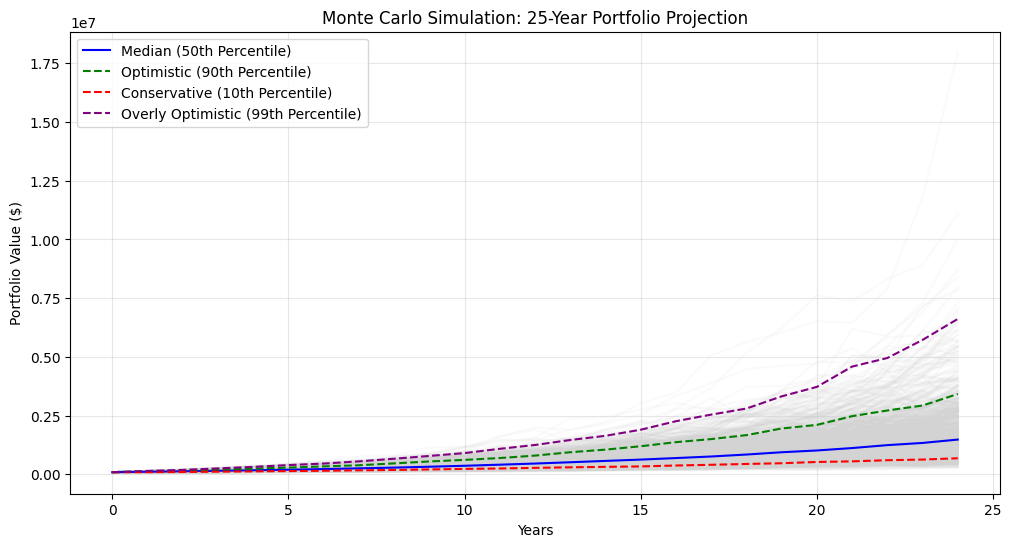

--- Simulation Summary after 25 years ---
Median Outcome: $1,478,510.36
10th Percentile (Worst Case): $682,982.82
90th Percentile (Best Case): $3,417,720.37
99th Percentile (Just for Fun): $6,614,505.17


In [15]:
plt.figure(figsize=(12, 6))
plt.plot(results, color='lightgray', alpha=0.1) # Plot individual paths
plt.plot(np.percentile(results, 50, axis=1), color='blue', label='Median (50th Percentile)')
plt.plot(np.percentile(results, 90, axis=1), color='green', linestyle='--', label='Optimistic (90th Percentile)')
plt.plot(np.percentile(results, 10, axis=1), color='red', linestyle='--', label='Conservative (10th Percentile)')
plt.plot(np.percentile(results, 99, axis=1), color='purple', linestyle='--', label='Overly Optimistic (99th Percentile)')

plt.title(f"Monte Carlo Simulation: {YEARS}-Year Portfolio Projection")
plt.xlabel("Years")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print Summary Statistics
final_balances = results[-1, :]
print(f"--- Simulation Summary after {YEARS} years ---")
print(f"Median Outcome: ${np.median(final_balances):,.2f}")
print(f"10th Percentile (Worst Case): ${np.percentile(final_balances, 10):,.2f}")
print(f"90th Percentile (Best Case): ${np.percentile(final_balances, 90):,.2f}")
print(f"99th Percentile (Just for Fun): ${np.percentile(final_balances, 99):,.2f}")

# In Retirement Amortization Schedule for Median Outcome

Adjust the following as needed:


*  how many years will you be in retirement


*   How much as a percentage will you withdraw each year
*   How much do you expect your investments to make in retirement
*   What do you think the inflation rate will be



In [16]:
# Calculate the Principal (Median Outcome)
final_balances = results[-1, :]
PRINCIPAL = np.median(final_balances)

# Withdrawal Schedule Parameters (Adjust these for your retirement)
RETIREMENT_YEARS = 40
WITHDRAWAL_RATE = 0.04 # 4% safe withdrawl rate (Adjust this as you see fit)
POST_RETIREMENT_GROWTH = 0.08  # Assumed portfolio growth during retirement (should be low for safety)
INFLATION_RATE = 0.03        # Assumed inflation rate (if you want to set this)

# Calculate initial withdrawal based on the 4% rule
INITIAL_WITHDRAWAL = PRINCIPAL * WITHDRAWAL_RATE

schedule = []
current_balance = PRINCIPAL
current_withdrawal = INITIAL_WITHDRAWAL

for year in range(1, RETIREMENT_YEARS + 1):
    # 1. Calculate Growth on Remaining Principal
    interest_earned = current_balance * POST_RETIREMENT_GROWTH

    # 2. Calculate New Balance Before Withdrawal
    balance_before_withdrawal = current_balance + interest_earned

    # 3. Calculate Ending Balance
    ending_balance = balance_before_withdrawal - current_withdrawal

    # Store the year's data
    schedule.append({
        'Year': year,
        'Starting Balance': current_balance,
        'Interest Earned': interest_earned,
        'Annual Withdrawal': current_withdrawal,
        'Ending Balance': ending_balance
    })

    # Prepare for the next year
    current_balance = ending_balance

    # Adjust withdrawal for inflation
    current_withdrawal *= (1 + INFLATION_RATE)

    # Safety Check: If balance drops too low, stop
    if current_balance < 0:
        current_balance = 0
        current_withdrawal = 0

# Create DataFrame for display and save to CSV
df_schedule = pd.DataFrame(schedule)
df_schedule = df_schedule.set_index('Year')

# List the monetary columns to be formatted
monetary_cols = ['Starting Balance', 'Interest Earned', 'Annual Withdrawal', 'Ending Balance']

# Define the currency format function (no scientific notation, 2 decimal places)
currency_format = lambda x: f"${x:,.2f}"

# Apply the currency formatting to the specified columns
df_formatted = df_schedule.copy()
for col in monetary_cols:
    df_formatted[col] = df_formatted[col].apply(currency_format)

# Print Summary
print(f"--- Monte Carlo Retirement Analysis ---")
print(f"Median Portfolio Value after {YEARS} years: ${PRINCIPAL:,.2f}")
print(f"Initial Annual Withdrawal (4% Rule): ${INITIAL_WITHDRAWAL:,.2f}")
print("\n--- Formatted Amortization Schedule (First 40 Years) ---")

# Print the formatted DataFrame
print(df_formatted.head(40).to_markdown(index=True, numalign='right', stralign='right'))
print("\n... (Full schedule continues)")


--- Monte Carlo Retirement Analysis ---
Median Portfolio Value after 25 years: $1,478,510.36
Initial Annual Withdrawal (4% Rule): $59,140.41

--- Formatted Amortization Schedule (First 40 Years) ---
|   Year |   Starting Balance |   Interest Earned |   Annual Withdrawal |   Ending Balance |
|-------:|-------------------:|------------------:|--------------------:|-----------------:|
|      1 |      $1,478,510.36 |       $118,280.83 |          $59,140.41 |    $1,537,650.77 |
|      2 |      $1,537,650.77 |       $123,012.06 |          $60,914.63 |    $1,599,748.21 |
|      3 |      $1,599,748.21 |       $127,979.86 |          $62,742.07 |    $1,664,986.00 |
|      4 |      $1,664,986.00 |       $133,198.88 |          $64,624.33 |    $1,733,560.55 |
|      5 |      $1,733,560.55 |       $138,684.84 |          $66,563.06 |    $1,805,682.34 |
|      6 |      $1,805,682.34 |       $144,454.59 |          $68,559.95 |    $1,881,576.98 |
|      7 |      $1,881,576.98 |       $150,526.16 |      